In [45]:
%matplotlib inline

import numpy as np
import pylab as plt
import pandas as pd
from glob import glob
from astropy.io import fits
from astropy.table import Table
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter as gfilter
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)
    
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [2]:
df = pd.read_csv('./data/sdss/metadata.csv')

def name_maker(x):    
    return 'spec-{:04d}-{:05d}-{:04d}.fits'.format(x['#plate'],x['mjd'],x['fiberid'])
df['filename'] = df.apply(name_maker, axis=1)

spec_list = glob('./data/sdss/*.fits')
n_spec = len(spec_list)

In [3]:
hdul = fits.open(spec_list[0])  # open a FITS file
data = hdul[1].data  # assume the first extension is a table
tdata = Table(data)
tdata

flux,loglam,ivar,and_mask,or_mask,wdisp,sky,model
float32,float32,float32,int32,int32,float32,float32,float32
13.381691,3.5787,0.030814009,0,201326592,1.2777864,12.097817,14.161554
16.375086,3.5788,0.0,0,201326592,1.2774847,11.600357,14.195818
19.367666,3.5789,0.03751277,0,201326592,1.2771764,10.907345,14.17663
17.692322,3.579,0.040465236,0,201326592,1.276867,10.459112,14.16853
16.812757,3.5791,0.040815443,0,67108864,1.2765576,10.097369,14.319841
15.46818,3.5792,0.051060665,0,0,1.2762598,9.67116,14.336131
10.818524,3.5793,0.054777205,0,0,1.2759517,9.437953,14.270202
11.302782,3.5794,0.058289256,0,0,1.2756431,9.099383,14.292547
15.053494,3.5795,0.0601058,0,0,1.2753346,8.74526,14.378578


In [4]:
X_train = []
y_train = []
X_test = []
y_test = []

lamins = []

lam_max = 3500
for i in range(n_spec):
    hdul = fits.open(spec_list[i])  # open a FITS file
    data = hdul[1].data  # assume the first extension is a table
    tdata = Table(data)
    mdl = np.array(tdata['model'])
    
    if np.array(tdata['loglam'])[0]>3.6 or mdl.shape[0]<lam_max:
        continue
    xx = mdl[:lam_max]
    
#     mdl = gfilter(mdl,10)
#     p_list = find_peaks(mdl)[0]
#     xx = np.zeros(50)
#     xx[:len(p_list):2] = np.array(tdata['loglam'])[p_list][:25]
#     xx[1:len(p_list):2] = np.array(tdata['model'])[p_list][:25]

#     inds = np.argsort(mdl)[::-1]
#     xx = np.array(tdata['loglam'])[inds][:1000]

    z = df[df['filename']==spec_list[i].split('/')[-1]]['z'].values[0]
    zclass = int(10*(z-1))
    zhotv = np.zeros(10)
    zhotv[zclass] = 1
    if i<n_spec//2:
        X_train.append(xx)
        y_train.append(zhotv)
    else:
        X_test.append(xx)
        y_test.append(zhotv)
    # tdata

In [5]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
input_dim = X_train.shape[1]

X_train = np.expand_dims(X_train,-1)
X_test = np.expand_dims(X_test,-1)

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1581, 3500, 1) (1581, 10) (1580, 3500, 1) (1580, 10)


In [6]:
# num = 100
# for i in range(num):
#     plt.plot(X_train[i,:],color=(1.*(num-i)/num,1.*i/num,0),alpha=0.1)

In [7]:
# model = Sequential()
# model.add(Dense(128, activation='relu', input_dim=input_dim))
# model.add(Dense(64, activation='relu')) 
# model.add(Dense(32, activation='relu'))
# model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(10, activation='sigmoid'))

In [12]:
model = Sequential()
model.add(Conv1D(10, 10, strides=1))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(10, 10, strides=1))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(10, 10, strides=1))
model.add(MaxPooling1D(pool_size=3))             
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='sigmoid'))

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [14]:
model.fit(X_train,y_train,epochs=100,batch_size=100,verbose=0)

In [15]:
model.evaluate(X_test,y_test)

1580/1580 [==============================] - 0s 300us/step


[0.35916550955440424, 0.9000000001508979]

In [16]:
y_pred = model.predict(X_test)
y_true = y_test.argmax(axis=1)
y_pred = y_pred.argmax(axis=1)

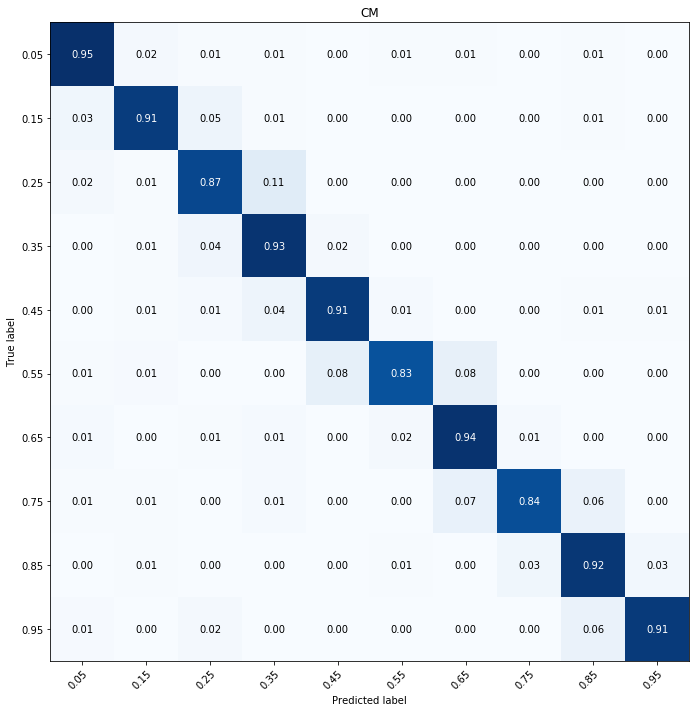

In [46]:
plot_confusion_matrix(y_true, y_pred,
                      ['{:4.2f}'.format(i+0.05) for i in np.linspace(0,1,10,endpoint=0)],
                      normalize=1,title='CM')